# Modeling a Recommendation System for Goodreads Books

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Clustering Data by KMeans
The data collected in the goodreads dataset is not labeled and therefore requires unsupervised learning. We can cluster the data into groups and use those grouped labels as a means to determine the nearest neighbors within those groups.
<br> We begin by first reducing the dimensionality of the data through SVD. From there, we can need to determine how many categories it makes sense to cluster the dataset. This can be accomplished by looking at the the elbow curve of the inertias of KMeans clustering.

In [2]:
# Export clean dataset from folder "Clean_data"
df = pd.read_csv('Clean_data\clean_books.csv').drop(columns = 'Unnamed: 0')

In [3]:
# Assigning variable "data" to average_rating and ratings_count
data = df[['average_rating','ratings_count', 'text_reviews_count']]

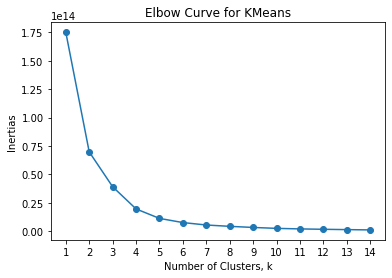

In [4]:
# Create elbow curve of kmeans clusters
inertias =[]
for k in range(1,15):
    k_means = KMeans(n_clusters = k)
    k_means.fit(data)
    inertias.append(k_means.inertia_)

# Plot Elbow Curve
plt.plot(range(1,15), inertias, '-o')
plt.xlabel("Number of Clusters, k")
plt.ylabel("Inertias")
plt.title("Elbow Curve for KMeans")
plt.xticks(range(1,15))
plt.show()

Looking above, the number of clusters (k) could be 4 or 5, but we will try out 5 since afterwards the inertias definetly level out after it, and it is therefore likely the point of elbow.

In [5]:
# Call instance of SVD
svd = TruncatedSVD()

# Call instance of kmeans with n_clusters = 5
kmeans = KMeans(n_clusters= 5)

# Make a pipeline
pipeline = make_pipeline(svd, kmeans)

# Fit pipeline
pipeline.fit(data)

Pipeline(memory=None,
         steps=[('truncatedsvd',
                 TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
                              random_state=None, tol=0.0)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=5, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [6]:
# Acquire the labels from pipeline
labels = pipeline.predict(data)

# Align labels from pipeline with dataset
labeled_df = pd.read_csv('Clean_data\clean_books.csv').drop(columns = 'Unnamed: 0')
labeled_df['label'] = labels

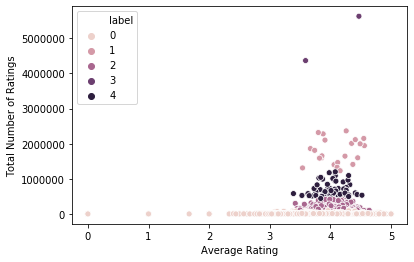

In [7]:
# Plot average rating by ratings counts, with clusters labeled
sns.scatterplot(labeled_df.average_rating, labeled_df.ratings_count, hue= labeled_df.label, legend='full')
plt.xlabel("Average Rating")
plt.ylabel("Total Number of Ratings")
plt.show()

From the graph above, we can see the 5 labeled clusters that a book can fall into. However, it seems that 2 points in this grouping are outliers. We can check the number of books per labeled group by checking the value counts of the dataframe.

In [8]:
# Look at how many books are in each labeled group
pd.value_counts(labeled_df.label)

0    13257
2      357
4       75
1       23
3        2
Name: label, dtype: int64

It is confirmed then that 2 books have their own category and are skewing the rest of the dataset categories. If we remove these outliers, we will likely get a cleaner split in the data and better clustering.

In [35]:
# Locating 2 books in own category
labeled_df[labeled_df.label==3]

,bookID,title,primary_a,secondary_a,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,label
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390,3
12243,41865,Twilight (Twilight #1),Stephenie Meyer,NaN,3.59,0316015849,9780316015844,eng,498,4367341,93619,3


In [10]:
# Dropping books from dataframe
new_df = df.drop([2,12243])

In [11]:
# Making new dataframe for pipeline
new_data = new_df[['average_rating','ratings_count', 'text_reviews_count']]

# Fit pipeline with new data
pipeline.fit(new_data)

Pipeline(memory=None,
         steps=[('truncatedsvd',
                 TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
                              random_state=None, tol=0.0)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=5, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [12]:
# New labels for datset
new_labels = pipeline.predict(new_data)

# Dataframe aligning labels with data
new_df['label'] = new_labels

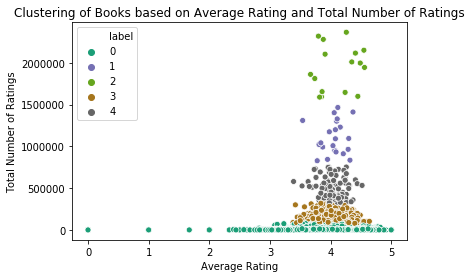

In [13]:
# Plot average rating by ratings counts, with clusters newly labeled
sns.scatterplot(new_df.average_rating, new_df.ratings_count, hue = new_df.label, palette= 'Dark2', legend='full')
plt.xlabel("Average Rating")
plt.ylabel("Total Number of Ratings")
plt.title("Clustering of Books based on Average Rating and Total Number of Ratings")
plt.show()

The 5 groups of the kmeans clustering are more distributed now. From here, using the labels we have created, we can use K-NearestNeighbor to look at how many books could be recommended based on the similiarity of a single book.

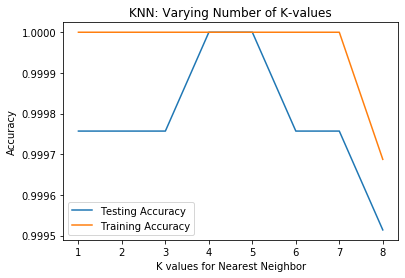

In [14]:
# Spliting the data into X and Y
X = new_df[['average_rating', 'ratings_count','text_reviews_count']].values
y = new_df['label'].values

# Train Test split of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

neighbors = np.arange(1,9)
train_accuracy = np.empty(len(neighbors))
testing_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    # Create a knn with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit data to knn
    knn.fit(X_train, y_train)
    
    # Training accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Testing accuracy
    testing_accuracy[i] = knn.score(X_test, y_test)

# Plot testing 
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False)
plt.plot(neighbors, testing_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.xlabel("K values for Nearest Neighbor")
plt.ylabel("Accuracy")
plt.title("KNN: Varying Number of K-values")
plt.legend()
plt.show()


While 4 or 5 seem to be good for both training and testing scores, this is because with different random states, the graph above produces different results. However, k=5 consistantly produces good results with high accuracy. The best value for K would be 5, meaning we could use KNN to find the 5 nearest neighbors to any book title on our list that a person might submit.

In [15]:
# Create KNN with k=5 and the data we have
knn_5 = KNeighborsClassifier(n_neighbors=5)

# Fit knn_5 to data
knn_5.fit(X, y)

# Find 5 closest neighbors to a data point by getting the distances and indices
distances, indices = knn_5.kneighbors()

# Checking length of indices to confirm size
len(indices)

13712

In [16]:
# Confirming length of dataframe matches length of indices
len(new_df)

13712

In [17]:
# Checking contents of indices
indices

array([[    1,    24,  2507,  6065,  2504],
       [   24,     0,  2504,  5299,  2507],
       [ 5651,  5448,  6514,  9738, 10353],
       ...,
       [11440, 13069, 13459,  5695,  7417],
       [ 7708,  8758,  3766,  4148, 10601],
       [  389,  8027,  5184,  4628, 10126]], dtype=int64)

In [18]:
# Convert indices array into series
similiar_books =pd.Series(indices.tolist(), name = "Similar Titles")

# Produce final dataframe with indices of 5 closest books
final_df = new_df.reset_index(drop=True)
final_df["Similar Titles"] = similiar_books

# Check head
final_df.head()

,bookID,title,primary_a,secondary_a,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,label,Similar Titles
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249,2,"[1, 24, 2507, 6065, 2504]"
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613,2,"[24, 0, 2504, 5299, 2507]"
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,NaN,4.41,0439554896,9780439554893,eng,352,6267,272,0,"[5651, 5448, 6514, 9738, 10353]"
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964,2,"[5299, 2504, 339, 24, 1]"
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling,Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,38872,154,0,"[387, 70, 10481, 1935, 3705]"


In [19]:
# Check tail
final_df.tail()

,bookID,title,primary_a,secondary_a,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count,label,Similar Titles
13707,47699,M Is for Magic,Neil Gaiman,Teddy Kristiansen,3.82,0061186422,9780061186424,eng,260,11317,1060,0,"[8116, 13120, 10528, 3823, 1607]"
13708,47700,Black Orchid,Neil Gaiman,Dave McKean,3.72,0930289552,9780930289553,eng,160,8710,361,0,"[2568, 10847, 7141, 5661, 6524]"
13709,47701,InterWorld (InterWorld #1),Neil Gaiman,Michael Reaves,3.53,0061238961,9780061238963,en-US,239,14334,1485,0,"[11440, 13069, 13459, 5695, 7417]"
13710,47708,The Faeries' Oracle,Brian Froud,Jessica Macbeth,4.43,0743201116,9780743201117,eng,224,1550,38,0,"[7708, 8758, 3766, 4148, 10601]"
13711,47709,The World of The Dark Crystal,Brian Froud,NaN,4.29,1862056242,9781862056244,eng,132,3572,33,0,"[389, 8027, 5184, 4628, 10126]"


In [31]:
# Define a function that will when given a title of a book within the dataframe, 
# returns the top 5 books closest to it.

def Books_Recommended(book=None, ID=None):
    # Check if book is not in dataframe
    if final_df[final_df.title.str.match(f'.*?{book}', case=False)].title.values.size == 0:
        return f'Book title "{book}" not found in database. Try another title.'
    
    # Check if there is only 1 copy of the title
    if final_df[final_df.title.str.match(f'.*?{book}', case=False)].title.values.size == 1:
        
        # Find row for particular title
        book_row = final_df[final_df.title.str.match(f'.*?{book}', case=False)]
        
        # Select cell in row that has list of indices for similiar titles
        closest_books_indices = book_row['Similar Titles']
        closest_books_titles = []
        
        # Cycle through similar titles, printing recommended titles in order of most similar. 
        for item in closest_books_indices:
            recommended_book = final_df.title[item].values.tolist()
        return print(f'The top 5 books similiar to "{book}" are (in order):\
                 \n1. {recommended_book[0]}\
                 \n2. {recommended_book[1]}\
                 \n3. {recommended_book[2]}\
                 \n4. {recommended_book[3]}\
                 \n5. {recommended_book[4]}')
    
    # If bookID is used instead of title, same method as above
    if ID in final_df.bookID.values:
        book_row = final_df[final_df.bookID == ID]
        closest_books_indices = book_row['Similar Titles']
        closest_books_titles = []
        
        for item in closest_books_indices:
            recommended_book = final_df.title[item].values.tolist()
        return print(f'The top 5 books similiar to "{book_row.title.to_string(index=False)}" are (in order):\
                 \n1. {recommended_book[0]}\
                 \n2. {recommended_book[1]}\
                 \n3. {recommended_book[2]}\
                 \n4. {recommended_book[3]}\
                 \n5. {recommended_book[4]}')
    
    # If too many titles match input, returns all possible titles with bookID to select by
    else:
        possible_books = final_df[final_df.title.str.match(f'.*?{book}', case=False)]
        possible_titles = possible_books[['title','bookID']].to_string(index=False)
        return print(f'There are too many books with a similar title.\
        \nPlease set ID based on Book ID below: \n{possible_titles}')

In [32]:
# Testing with partial title of full book
Books_Recommended("dark crystal")

The top 5 books similiar to "dark crystal" are (in order):                 
1. Tyler's Ultimate: Brilliant Simple Food to Make Any Time                 
2. Classical Drawing Atelier: A Contemporary Guide to Traditional Studio Practice                 
3. The Heritage of Shannara (Heritage of Shannara  #1-4)                 
4. Young Warriors: Stories of Strength                 
5. Silver Bullet


In [33]:
# Testing with partial title of a book with multiple entries
Books_Recommended("harry potter and the half")

There are too many books with a similar title.        
Please set ID based on Book ID below: 
                                             title  bookID
 Harry Potter and the Half-Blood Prince (Harry ...       1
 Harry Potter and the Half-Blood Prince (Harry ...    2005


In [34]:
# Testing with bookID as 
Books_Recommended(ID=1)

The top 5 books similiar to " Harry Potter and the Half-Blood Prince (Harry ..." are (in order):                 
1. Harry Potter and the Order of the Phoenix (Harry Potter  #5)                 
2. The Fellowship of the Ring (The Lord of the Rings  #1)                 
3. Lord of the Flies                 
4. Romeo and Juliet                 
5. Animal Farm


Book recommendation system works well, and is able to handle multiple types of user input entries in order to locate the book they might be seeking. Future projects with this recommendation system would be to use user data and reveiws in conjunction with clustered grouping, and perhaps even author preference in order to find further similarities.